In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df1 = pd.read_excel("/kaggle/input/online-retail/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df2 = pd.read_excel("/kaggle/input/online-retail/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [3]:
df1 = df1.dropna(subset=['Customer ID'])
df1['Description'].fillna('No Description', inplace=True)
df1.drop(df1[df1["Invoice"].str.contains("C", na=False)].index, inplace=True)

df2 = df2.dropna(subset=['Customer ID'])
df2['Description'].fillna('No Description', inplace=True)
df2.drop(df2[df2["Invoice"].str.contains("C", na=False)].index, inplace=True)

/tmp/ipykernel_68/862019242.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Description'].fillna('No Description', inplace=True)
/tmp/ipykernel_68/862019242.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [4]:
df = pd.concat([df1, df2])

In [5]:
df['TotalPrice'] = df['Quantity'] * df['Price']
customer_data = df.groupby('Customer ID').agg({
    'TotalPrice': 'sum',
    'Invoice': 'nunique',
    'Quantity': 'sum'
}).reset_index()

In [6]:
customer_data.columns = ['Customer ID', 'TotalSpent', 'NumPurchases', 'TotalQuantity']

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalSpent', 'NumPurchases', 'TotalQuantity']])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

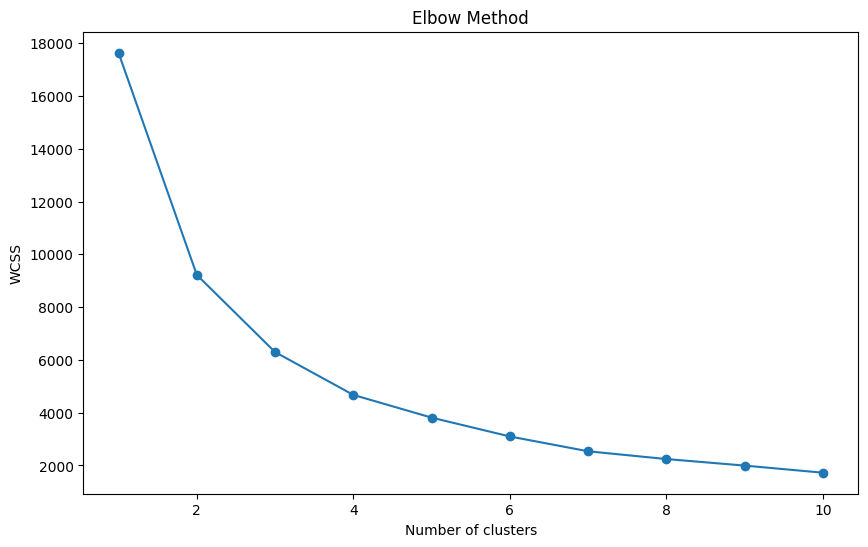

In [8]:
ElbowPoints = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    ElbowPoints.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), ElbowPoints, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [9]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpent': ['mean', 'std'],
    'NumPurchases': ['mean', 'std'],
    'TotalQuantity': ['mean', 'std'],
    'Customer ID': 'count'
}).reset_index()

print(cluster_summary)

  Cluster     TotalSpent                NumPurchases              \
                    mean            std         mean         std   
0       0    1417.846104    1861.614527     4.005711    3.550962   
1       1  388765.196000  172597.909261   198.800000  111.479595   
2       2   13238.198771   10059.626288    27.819048   14.528570   
3       3   90838.966500   53894.019099    91.214286   81.393583   

   TotalQuantity               Customer ID  
            mean           std       count  
0     828.570744   1120.808111        5428  
1  212321.400000  88450.861015           5  
2    7530.192857   6456.353089         420  
3   71398.250000  39088.208206          28  


In [11]:
def describe_clusters(cluster_summary):
    descriptions = []
    for i, row in cluster_summary.iterrows():
        cluster_id = row['Cluster']
        total_spent_mean = row['TotalSpent']['mean']
        num_purchases_mean = row['NumPurchases']['mean']
        total_quantity_mean = row['TotalQuantity']['mean']
        customer_count = row['Customer ID']['count']
        
        description = (f"Cluster {cluster_id}:\n"
                       f"- Number of Customers: {customer_count}\n"
                       f"- Average Total Spent: ${total_spent_mean:.2f}\n"
                       f"- Average Number of Purchases: {num_purchases_mean:.2f}\n"
                       f"- Average Total Quantity: {total_quantity_mean:.2f}\n")
        descriptions.append(description)
    
    return descriptions

In [12]:
cluster_descriptions = describe_clusters(cluster_summary)
for desc in cluster_descriptions:
    print(desc)

Cluster     0.0
Name: 0, dtype: float64:
- Number of Customers: 5428.0
- Average Total Spent: $1417.85
- Average Number of Purchases: 4.01
- Average Total Quantity: 828.57

Cluster     1.0
Name: 1, dtype: float64:
- Number of Customers: 5.0
- Average Total Spent: $388765.20
- Average Number of Purchases: 198.80
- Average Total Quantity: 212321.40

Cluster     2.0
Name: 2, dtype: float64:
- Number of Customers: 420.0
- Average Total Spent: $13238.20
- Average Number of Purchases: 27.82
- Average Total Quantity: 7530.19

Cluster     3.0
Name: 3, dtype: float64:
- Number of Customers: 28.0
- Average Total Spent: $90838.97
- Average Number of Purchases: 91.21
- Average Total Quantity: 71398.25



/tmp/ipykernel_68/2343671113.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legend_text, legend_handle in zip(legend_labels, scatter.legend_.legendHandles):


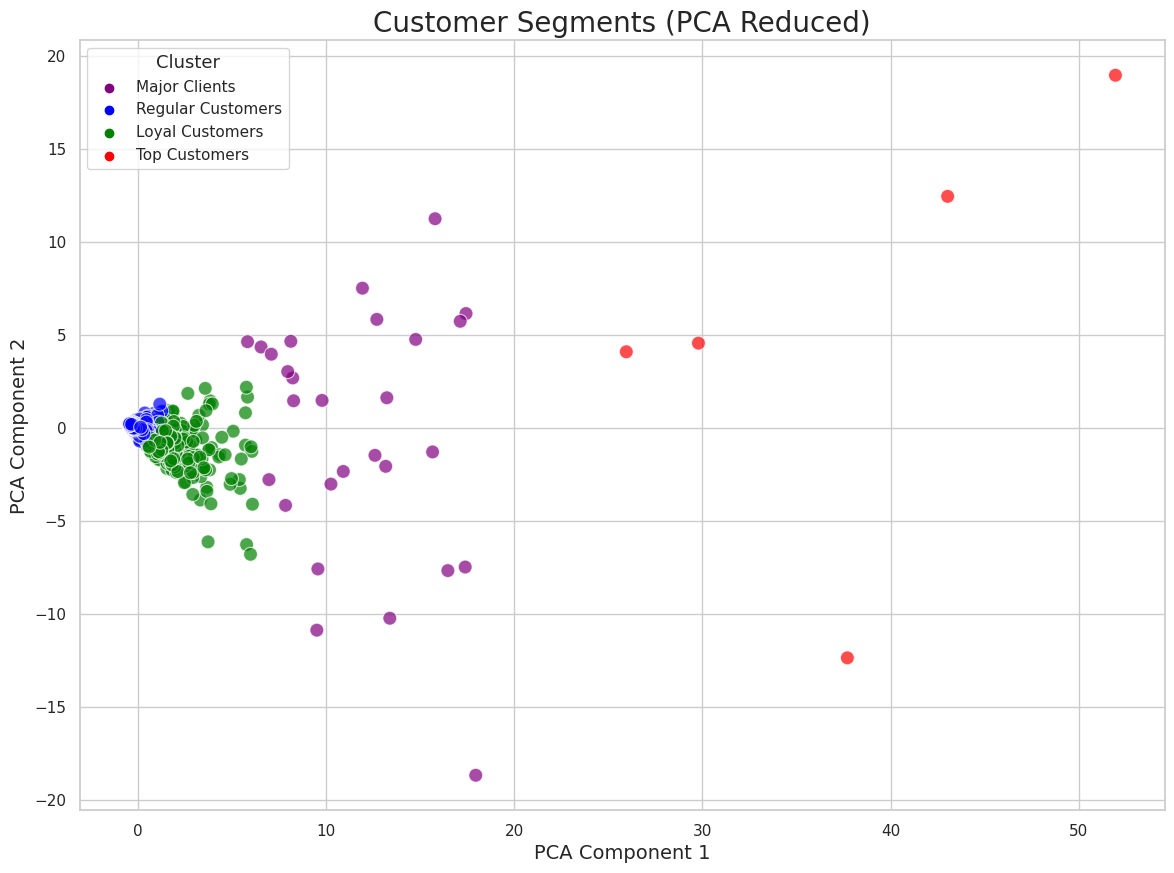

In [16]:
# Applying PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

cluster_mapping = {
    0: "Regular Customers",
    1: "Top Customers",
    2: "Loyal Customers",
    3: "Major Clients"
}

customer_data['ClusterName'] = customer_data['Cluster'].map(cluster_mapping)

palette = {
    "Regular Customers": "blue",
    "Top Customers": "red",
    "Loyal Customers": "green",
    "Major Clients": "purple"
}

sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

scatter = sns.scatterplot(
    x=pca_components[:, 0], 
    y=pca_components[:, 1], 
    hue=customer_data['ClusterName'], 
    palette=palette, 
    s=100,
    edgecolor='w', 
    alpha=0.7
)

legend_labels = customer_data['ClusterName'].unique()
for legend_text, legend_handle in zip(legend_labels, scatter.legend_.legendHandles):
    legend_handle.set_sizes([100])
    legend_handle.set_edgecolor('w')

plt.title('Customer Segments (PCA Reduced)', fontsize=20)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.legend(title='Cluster', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.show()